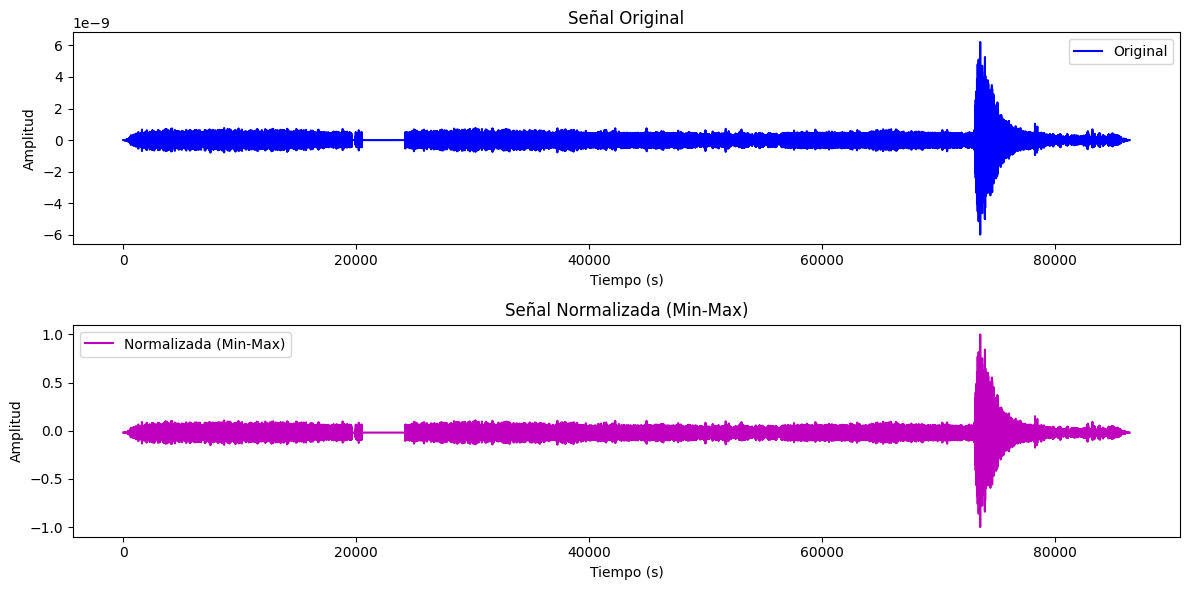

In [41]:
from obspy import read
import numpy as np
import matplotlib.pyplot as plt

# Ruta al archivo .mseed
data_directory = '../../../data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1970-01-19HR00_evid00002.mseed'
mseed_file = f'{data_directory}'

# Leer el archivo mseed
st = read(mseed_file)
tr = st[0].copy()  # Obtener la primera traza

# Aplicar el filtro de banda
minfreq = 0.5
maxfreq = 6
tr.filter('bandpass', freqmin=minfreq, freqmax=maxfreq)

# Obtener datos de la traza filtrada
tr_times = tr.times()
tr_data = tr.data

# Normalización Min-Max
min_val = np.min(tr_data)
max_val = np.max(tr_data)
tr_data_minmax = 2 * (tr_data - min_val) / (max_val - min_val) - 1  # Escalado entre -1 y 1

# Visualizar la señal original y la señal normalizada
plt.figure(figsize=(12, 6))

# Señal original
plt.subplot(2, 1, 1)
plt.plot(tr_times, tr_data, 'b-', label='Original')
plt.title('Señal Original')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()

# Señal normalizada (Min-Max)
plt.subplot(2, 1, 2)
plt.plot(tr_times, tr_data_minmax, 'm-', label='Normalizada (Min-Max)')
plt.title('Señal Normalizada (Min-Max)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()

plt.tight_layout()
plt.show()

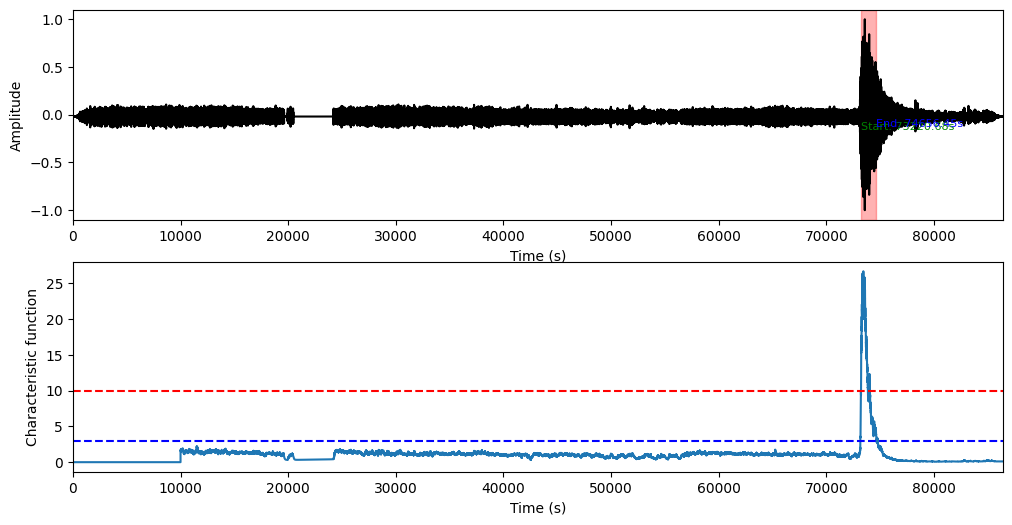

In [42]:
from obspy.signal.trigger import recursive_sta_lta, trigger_onset
import matplotlib.pyplot as plt
import numpy as np

# Obtener la frecuencia de muestreo antes de normalizar
df = tr.stats.sampling_rate

# Aplicar un filtro de banda antes del análisis
tr.filter('bandpass', freqmin=minfreq, freqmax=maxfreq)  # Ajustar el filtro de banda

# Longitudes de ventana STA/LTA en segundos
sta_len = 60#60  # Ventana de corto plazo
lta_len = 10000#1800  # Ventana de largo plazo

# Ejecutar STA/LTA recursivo
cft = recursive_sta_lta(tr_data_minmax, int(sta_len * df), int(lta_len * df))

# Definir umbrales para la detección (ajustados)
threshold_on = 10 # Incrementar umbral de activación
threshold_off = 3 # Incrementar umbral de desactivación

# Detectar eventos
on_off = trigger_onset(cft, threshold_on, threshold_off)

# Filtrar detecciones cortas (menos de 60 segundos)
min_duration = 60 * df
on_off_filtered = [event for event in on_off if (event[1] - event[0]) > min_duration]

# Fusionar detecciones cercanas (si la diferencia entre ellas es menor a un cierto tiempo)
min_gap = 5000  # Número de muestras entre eventos detectados para fusionarlos
merged_on_off = []
if len(on_off_filtered) > 0:
    current_event = on_off_filtered[0]
    for i in range(1, len(on_off_filtered)):
        if on_off_filtered[i][0] - current_event[1] < min_gap:
            current_event[1] = on_off_filtered[i][1]  # Fusionar eventos
        else:
            merged_on_off.append(current_event)
            current_event = on_off_filtered[i]
    merged_on_off.append(current_event)

# Visualizar la función característica y las detecciones
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

# Gráfico de la señal con detecciones
ax[0].plot(tr.times(), tr_data_minmax, 'k')  # Usar la señal normalizada
for start, end in merged_on_off:
    # Convertir índices a tiempo en segundos
    start_time = start / df
    end_time = end / df
    
    # Resaltar el intervalo detectado
    ax[0].axvspan(tr.times()[start], tr.times()[end], color='red', alpha=0.3)
    
    # Anotar el tiempo de inicio y fin
    ax[0].text(tr.times()[start], tr_data_minmax[start], f'Start: {start_time:.2f}s', color='green', fontsize=8, verticalalignment='bottom')
    ax[0].text(tr.times()[end], tr_data_minmax[end], f'End: {end_time:.2f}s', color='blue', fontsize=8, verticalalignment='top')

ax[0].set_xlim([min(tr.times()), max(tr.times())])
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')

# Gráfico de la función característica STA/LTA
ax[1].plot(tr.times(), cft)
ax[1].axhline(y=threshold_on, color='r', linestyle='--')
ax[1].axhline(y=threshold_off, color='b', linestyle='--')
ax[1].set_xlim([min(tr.times()), max(tr.times())])
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Characteristic function')

plt.show()

In [1]:
i=0

for start_test,end_test in merged_on_off:
    i+=1
    print(f'{i}. Event detected at {start_test/df} s - {end_test/df} s')

NameError: name 'merged_on_off' is not defined

In [20]:
# Supongamos que tenemos el tiempo verdadero del evento
true_event_time = 4440.0# En segundos, por ejemplo

# Lista para almacenar errores absolutos
absolute_errors = []

# Calcular el error absoluto para cada detección
for start, end in merged_on_off:
    # Convertir los índices a tiempo en segundos
    detected_event_time = start/ df
    
    # Error absoluto
    error_absolute = np.abs(detected_event_time - true_event_time)
    absolute_errors.append(error_absolute)
    print(f"Tiempo de evento verdadero: {true_event_time}s")
    print(f"Tiempo de evento detectado: {detected_event_time:.2f}s")
    print(f"Error absoluto: {error_absolute:.2f} segundos")

# Mostrar el error absoluto promedio
if absolute_errors:
    average_error = np.mean(absolute_errors)
    print(f"\nError absoluto promedio: {average_error:.2f} segundos")
else:
    print("No se detectaron eventos para calcular el error.")

Tiempo de evento verdadero: 4440.0s
Tiempo de evento detectado: 4673.96s
Error absoluto: 233.96 segundos

Error absoluto promedio: 233.96 segundos
